# 11. GEOSPATIAL ANALYSIS

# 11.5. Proximity Analysis

# 11.5.1. COURS

In [1]:
import folium
from folium import Marker, GeoJson
from folium.plugins import HeatMap

import pandas as pd
import geopandas as gpd

In [20]:
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

In [2]:
releases = gpd.read_file("geospatial-learn-course-data/input//toxic_release_pennsylvania/toxic_release_pennsylvania.shp") 
releases.head()

,YEAR,CITY,COUNTY,ST,LATITUDE,LONGITUDE,CHEMICAL,UNIT_OF_ME,TOTAL_RELE,geometry
0,2016,PHILADELPHIA,PHILADELPHIA,PA,40.005901,-75.072103,FORMIC ACID,Pounds,0.160,POINT (2718560.227 256380.179)
1,2016,PHILADELPHIA,PHILADELPHIA,PA,39.920120,-75.146410,ETHYLENE GLYCOL,Pounds,13353.480,POINT (2698674.606 224522.905)
2,2016,PHILADELPHIA,PHILADELPHIA,PA,40.023880,-75.220450,CERTAIN GLYCOL ETHERS,Pounds,104.135,POINT (2676833.394 261701.856)
3,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,LEAD COMPOUNDS,Pounds,1730.280,POINT (2684030.004 221697.388)
4,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,BENZENE,Pounds,39863.290,POINT (2684030.004 221697.388)


In [4]:
stations = gpd.read_file("geospatial-learn-course-data/input/PhillyHealth_Air_Monitoring_Stations/PhillyHealth_Air_Monitoring_Stations.shp")
stations.head()

,SITE_NAME,ADDRESS,BLACK_CARB,ULTRAFINE_,CO,SO2,OZONE,NO2,NOY_NO,PM10,...,PAMS_VOC,TSP_11101,TSP_METALS,TSP_LEAD,TOXICS_TO1,MET,COMMUNITY_,LATITUDE,LONGITUDE,geometry
0,LAB,1501 East Lycoming Avenue,N,N,Y,N,Y,Y,Y,N,...,Y,N,Y,N,y,N,N,40.008606,-75.097624,POINT (2711384.641 257149.310)
1,ROX,Eva and Dearnley Streets,N,N,N,N,N,N,N,N,...,N,N,Y,N,Y,N,N,40.050461,-75.236966,POINT (2671934.290 271248.900)
2,NEA,Grant Avenue and Ashton Street,N,N,N,N,Y,N,N,N,...,N,N,N,N,N,Y,N,40.072073,-75.013128,POINT (2734326.638 280980.247)
3,CHS,500 South Broad Street,N,N,N,N,N,N,N,N,...,N,N,Y,N,Y,N,N,39.944510,-75.165442,POINT (2693078.580 233247.101)
4,NEW,2861 Lewis Street,N,N,Y,Y,Y,N,Y,Y,...,N,Y,N,Y,N,Y,N,39.991688,-75.080378,POINT (2716399.773 251134.976)


# Measuring distance

In [5]:
print(stations.crs)
print(releases.crs)

epsg:2272
epsg:2272


In [6]:
# Select one release incident in particular
recent_release = releases.iloc[360]

# Measure distance from release to each station
distances = stations.geometry.distance(recent_release.geometry)
distances

0     44778.509761
1     51006.456589
2     77744.509207
3     14672.170878
4     43753.554393
5      4711.658655
6     23197.430858
7     12072.823097
8     79081.825506
9      3780.623591
10    27577.474903
11    19818.381002
dtype: float64

In [7]:
print('Mean distance to monitoring stations: {} feet'.format(distances.mean()))

Mean distance to monitoring stations: 33516.28487007786 feet


In [8]:
print('Closest monitoring station ({} feet):'.format(distances.min()))
print(stations.iloc[distances.idxmin()][["ADDRESS", "LATITUDE", "LONGITUDE"]])

Closest monitoring station (3780.623590556444 feet):
ADDRESS      3100 Penrose Ferry Road
LATITUDE                     39.9128
LONGITUDE                   -75.1854
Name: 9, dtype: object


# Creating a buffer

In [10]:
two_mile_buffer = stations.geometry.buffer(2*5280)
two_mile_buffer.head()

0    POLYGON ((2721944.641 257149.310, 2721893.792 ...
1    POLYGON ((2682494.290 271248.900, 2682443.441 ...
2    POLYGON ((2744886.638 280980.247, 2744835.789 ...
3    POLYGON ((2703638.580 233247.101, 2703587.731 ...
4    POLYGON ((2726959.773 251134.976, 2726908.924 ...
dtype: geometry

In [11]:
# Create map with release incidents and monitoring stations
m = folium.Map(location=[39.9526,-75.1652], zoom_start=11)

HeatMap(data=releases[['LATITUDE', 'LONGITUDE']], radius=15).add_to(m)
for idx, row in stations.iterrows():
    Marker([row['LATITUDE'], row['LONGITUDE']]).add_to(m)
    
# Plot each polygon on the map
GeoJson(two_mile_buffer.to_crs(epsg=4326)).add_to(m)

# Show the map
m

Type: <class 'shapely.geometry.multipolygon.MultiPolygon'>


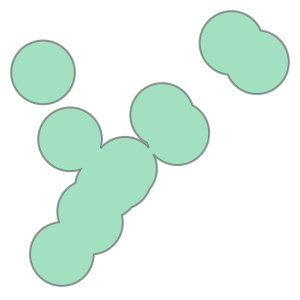

In [12]:
# Turn group of polygons into single multipolygon
my_union = two_mile_buffer.geometry.unary_union
print('Type:', type(my_union))

# Show the MultiPolygon object
my_union

In [13]:
# The closest station is less than two miles away
my_union.contains(releases.iloc[360].geometry)

True

In [14]:
# The closest station is less than two miles away
my_union.contains(releases.iloc[358].geometry)

False

# 11.5.2. EXERCICES

In [16]:
import math
import geopandas as gpd
import pandas as pd
from shapely.geometry import MultiPolygon

import folium
from folium import Choropleth, Marker
from folium.plugins import HeatMap, MarkerCluster

# 1) Visualize the collision data.

In [17]:
collisions = gpd.read_file("geospatial-learn-course-data/input/NYPD_Motor_Vehicle_Collisions/NYPD_Motor_Vehicle_Collisions.shp")
collisions.head()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET,CROSS STRE,OFF STREET,...,CONTRIBU_2,CONTRIBU_3,CONTRIBU_4,UNIQUE KEY,VEHICLE TY,VEHICLE _1,VEHICLE _2,VEHICLE _3,VEHICLE _4,geometry
0,07/30/2019,0:00,BRONX,10464,40.841100,-73.784960,"(40.8411, -73.78496)",None,None,121 PILOT STREET,...,Unspecified,None,None,4180045,Sedan,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,None,None,POINT (1043750.211 245785.815)
1,07/30/2019,0:10,QUEENS,11423,40.710827,-73.770660,"(40.710827, -73.77066)",JAMAICA AVENUE,188 STREET,None,...,None,None,None,4180007,Sedan,Sedan,None,None,None,POINT (1047831.185 198333.171)
2,07/30/2019,0:25,None,None,40.880318,-73.841286,"(40.880318, -73.841286)",BOSTON ROAD,None,None,...,None,None,None,4179575,Sedan,Station Wagon/Sport Utility Vehicle,None,None,None,POINT (1028139.293 260041.178)
3,07/30/2019,0:35,MANHATTAN,10036,40.756744,-73.984590,"(40.756744, -73.98459)",None,None,155 WEST 44 STREET,...,None,None,None,4179544,Box Truck,Station Wagon/Sport Utility Vehicle,None,None,None,POINT (988519.261 214979.320)
4,07/30/2019,10:00,BROOKLYN,11223,40.600090,-73.965910,"(40.60009, -73.96591)",AVENUE T,OCEAN PARKWAY,None,...,None,None,None,4180660,Station Wagon/Sport Utility Vehicle,Bike,None,None,None,POINT (993716.669 157907.212)


# 2) Understand hospital coverage.

In [18]:
hospitals = gpd.read_file("geospatial-learn-course-data/input/nyu_2451_34494/nyu_2451_34494.shp")
hospitals.head()

,id,name,address,zip,factype,facname,capacity,capname,bcode,xcoord,ycoord,latitude,longitude,geometry
0,317000001H1178,BRONX-LEBANON HOSPITAL CENTER - CONCOURSE DIVI...,1650 Grand Concourse,10457,3102,Hospital,415,Beds,36005,1008872.0,246596.0,40.843490,-73.911010,POINT (1008872.000 246596.000)
1,317000001H1164,BRONX-LEBANON HOSPITAL CENTER - FULTON DIVISION,1276 Fulton Ave,10456,3102,Hospital,164,Beds,36005,1011044.0,242204.0,40.831429,-73.903178,POINT (1011044.000 242204.000)
2,317000011H1175,CALVARY HOSPITAL INC,1740-70 Eastchester Rd,10461,3102,Hospital,225,Beds,36005,1027505.0,248287.0,40.848060,-73.843656,POINT (1027505.000 248287.000)
3,317000002H1165,JACOBI MEDICAL CENTER,1400 Pelham Pkwy,10461,3102,Hospital,457,Beds,36005,1027042.0,251065.0,40.855687,-73.845311,POINT (1027042.000 251065.000)
4,317000008H1172,LINCOLN MEDICAL & MENTAL HEALTH CENTER,234 E 149 St,10451,3102,Hospital,362,Beds,36005,1005154.0,236853.0,40.816758,-73.924478,POINT (1005154.000 236853.000)


In [22]:
m_2 = folium.Map(location=[40.7, -74], zoom_start=11) 

# Your code here: Visualize the hospital locations
# Add points to the map
for idx, row in hospitals.iterrows():
    Marker([row['latitude'], row['longitude']], popup=row['name']).add_to(m_2)
        
# Show the map
embed_map(m_2, "q_2.html")

# 3) When was the closest hospital more than 10 kilometers away?

In [23]:
coverage = gpd.GeoDataFrame(geometry=hospitals.geometry).buffer(10000)
my_union = coverage.geometry.unary_union
outside_range = collisions.loc[~collisions["geometry"].apply(lambda x: my_union.contains(x))]

In [24]:
percentage = round(100*len(outside_range)/len(collisions), 2)
print("Percentage of collisions more than 10 km away from the closest hospital: {}%".format(percentage))

Percentage of collisions more than 10 km away from the closest hospital: 15.12%


# 4) Make a recommender.

In [25]:
def best_hospital(collision_location):
    idx_min = hospitals.geometry.distance(collision_location).idxmin()
    my_hospital = hospitals.iloc[idx_min]
    name = my_hospital["name"]
    return name

# Test your function: this should suggest CALVARY HOSPITAL INC
print(best_hospital(outside_range.geometry.iloc[0]))

CALVARY HOSPITAL INC


# 5) Which hospital is under the highest demand?

In [26]:
highest_demand = outside_range.geometry.apply(best_hospital).value_counts().idxmax()

In [27]:
highest_demand

'JAMAICA HOSPITAL MEDICAL CENTER'

# 6) Where should the city construct new hospitals?

In [28]:
m_6 = folium.Map(location=[40.7, -74], zoom_start=11) 

coverage = gpd.GeoDataFrame(geometry=hospitals.geometry).buffer(10000)
folium.GeoJson(coverage.geometry.to_crs(epsg=4326)).add_to(m_6)
HeatMap(data=outside_range[['LATITUDE', 'LONGITUDE']], radius=9).add_to(m_6)
folium.LatLngPopup().add_to(m_6)

embed_map(m_6, 'm_6.html')

In [44]:
# Your answer here: proposed location of hospital 1
# Proposed location of hospital 1
lat_1 = 40.6714
long_1 = -73.8492

# Proposed location of hospital 2
lat_2 = 40.6702
long_2 = -73.7612


# Do not modify the code below this line
try:
    new_df = pd.DataFrame(
        {'Latitude': [lat_1, lat_2],
         'Longitude': [long_1, long_2]})
    new_gdf = gpd.GeoDataFrame(new_df, geometry=gpd.points_from_xy(new_df.Longitude, new_df.Latitude))
    new_gdf.crs = {'init' :'epsg:4326'}
    new_gdf = new_gdf.to_crs(epsg=2263)
    # get new percentage
    new_coverage = gpd.GeoDataFrame(geometry=new_gdf.geometry).buffer(10000)
    new_my_union = new_coverage.geometry.unary_union
    new_outside_range = outside_range.loc[~outside_range["geometry"].apply(lambda x: new_my_union.contains(x))]
    new_percentage = round(100*len(new_outside_range)/len(collisions), 2)
    print("(NEW) Percentage of collisions more than 10 km away from the closest hospital: {}%".format(new_percentage))

    
    # make the map
    m = folium.Map(location=[40.7, -74], zoom_start=11) 
    folium.GeoJson(coverage.geometry.to_crs(epsg=4326)).add_to(m)
    folium.GeoJson(new_coverage.geometry.to_crs(epsg=4326)).add_to(m)
    for idx, row in new_gdf.iterrows():
        Marker([row['Latitude'], row['Longitude']]).add_to(m)
    HeatMap(data=new_outside_range[['LATITUDE', 'LONGITUDE']], radius=9).add_to(m)
    folium.LatLngPopup().add_to(m)
    display(embed_map(m, 'q_6.html'))
except:
   print('error')

C:\Users\Outils\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


(NEW) Percentage of collisions more than 10 km away from the closest hospital: 11.96%
